<a href="https://colab.research.google.com/github/HariniRenganathan/HariniRenganathan/blob/main/colabs/captcha_ocr_tflite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tulasiram58827/ocr_tflite/blob/main/colabs/captcha_ocr_tflite.ipynb)

In [1]:
!pip install tf-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.8/641.8 MB 570.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.0 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.__version__

'2.19.0-dev20250120'

In [3]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0  6614k      0  0:00:01  0:00:01 --:--:-- 6614k


In [4]:

# Path to the data directory
data_dir = Path("./captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

char_to_num_dict = dict()
i = 0
for char in characters:
  char_to_num_dict[char] = i
  i+=1
num_to_char_dict = {value : key for key, value in char_to_num_dict.items()}
import json

with open('num_to_char.json', 'w') as fp:
    json.dump(num_to_char_dict, fp)

with open('char_to_num.json', 'w') as fp:
    json.dump(char_to_num_dict, fp)

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'3', 'c', 'g', '8', 'n', '4', '6', 'w', '2', 'f', '7', 'b', 'd', 'e', 'p', 'x', '5', 'm', 'y'}


In [6]:
from tensorflow.keras.layers import StringLookup

# Mapping characters to integers

char_to_num =StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)
print(char_to_num.get_vocabulary())
print(type(char_to_num))

# Mapping integers back to original characters
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'
['3', 'c', 'g', '8', 'n', '4', '6', 'w', '2', 'f', '7', 'b', 'd', 'e', 'p', 'x', '5', 'm', 'y']
<class 'keras.src.layers.preprocessing.string_lookup.StringLookup'>


In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

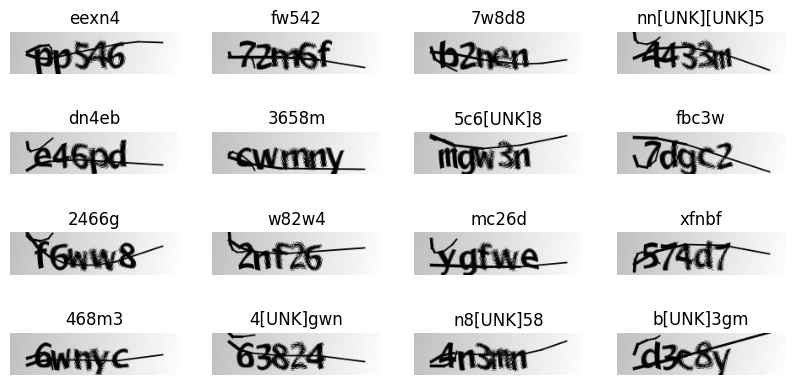

In [8]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [9]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 200, 50, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 200, 50, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 100, 25, 32)    │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 100, 25, 64)    │         18,496 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 50, 12, 64)     │              0 │ Conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 50, 768)        │              0 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 50, 64)         │         49,216 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 50, 64)         │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50, 256)        │        197,632 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 50, 128)        │        164,352 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 50, 20)         │          2,580 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 50, 20)         │              0 │ label[0][0],           │
│                           │                        │                │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 432,596 (1.65 MB)

 Trainable params: 432,596 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)


Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 277ms/step - loss: 509.0746 - val_loss: 253.1825
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 245ms/step - loss: 261.9064 - val_loss: 253.2300
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - loss: 261.8837 - val_loss: 253.1938
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 237ms/step - loss: 261.7344 - val_loss: 253.1774
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 231ms/step - loss: 261.8719 - val_loss: 253.2336
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - loss: 261.5241 - val_loss: 253.1356
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 237ms/step - loss: 261.4490 - val_loss: 253.0532
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - loss: 261.2593 - val_loss: 253.0424
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 230ms/step - loss: 261.1645 - val_loss: 252.8961
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 230ms/step - loss: 260.8951 - val_loss: 252.6423
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - loss: 260.7279 - val_l

In [19]:
image_layer = model.get_layer(name="image")
print("Image Layer Details:", image_layer)
print("Image Layer Input:", image_layer.input)  # Check if it's a list or tensor
print("Model Input:", model.input)  # To see the actual model inputs


Image Layer Details: <InputLayer name=image, built=True>
Image Layer Input: []
Model Input: [<KerasTensor shape=(None, 200, 50, 1), dtype=float32, sparse=False, ragged=False, name=image>, <KerasTensor shape=(None, None), dtype=float32, sparse=False, ragged=False, name=label>]


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 200, 50, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 200, 50, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 100, 25, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 100, 25, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 50, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 50, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 50, 64)              │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 50, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 50, 20)              │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 432,596 (1.65 MB)

 Trainable params: 432,596 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
tf.Tensor([14  5 14 12 13], shape=(5,), dtype=int64)
tf.Tensor([14 14  7 18 12], shape=(5,), dtype=int64)
tf.Tensor([14 17 13  3  6], shape=(5,), dtype=int64)
tf.Tensor([ 4  9  3 11  3], shape=(5,), dtype=int64)
tf.Tensor([ 2  0 12 18  6], shape=(5,), dtype=int64)
tf.Tensor([13 12  7  4 18], shape=(5,), dtype=int64)
tf.Tensor([ 6 16 13 11 17], shape=(5,), dtype=int64)
tf.Tensor([7 3 9 0 6], shape=(5,), dtype=int64)
tf.Tensor([ 6 11  5  6  2], shape=(5,), dtype=int64)
tf.Tensor([12 17 15 14  3], shape=(5,), dtype=int64)
tf.Tensor([ 9  9  4 15  4], shape=(5,), dtype=int64)
tf.Tensor([ 4 11  9 15 16], shape=(5,), dtype=int64)
tf.Tensor([ 0  5  9 15 17], shape=(5,), dtype=int64)
tf.Tensor([16 16 18  8 17], shape=(5,), dtype=int64)
tf.Tensor([18 10 15  3 14], shape=(5,), dtype=int64)
tf.Tensor([11 12 11 11  0], shape=(5,), dtype=int64)


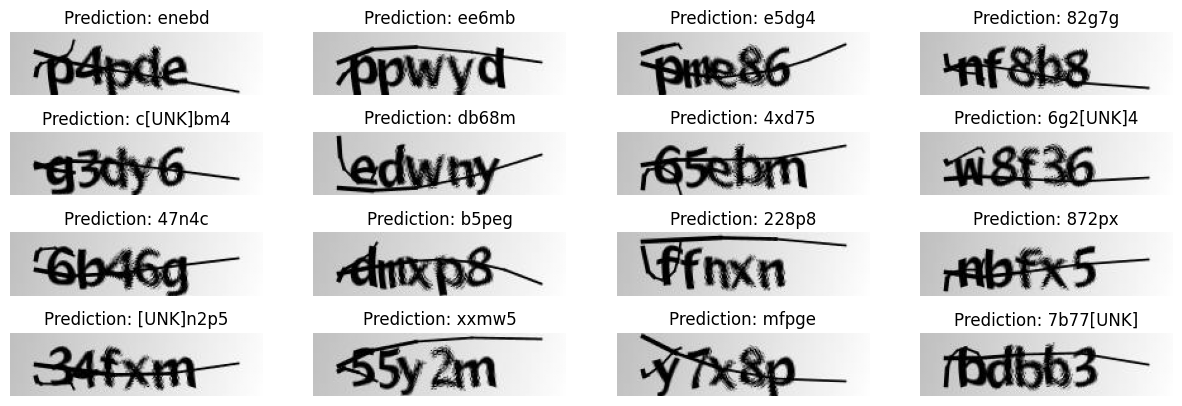

In [20]:
# Extract specific input tensor for 'image'
input_tensor = model.input[0]  # Use the first input tensor (image)
output_tensor = model.get_layer(name="dense2").output  # Use the output of 'dense2'

# Create the prediction model
prediction_model = keras.models.Model(inputs=input_tensor, outputs=output_tensor)
prediction_model.summary()  # Verify the structure of the submodel

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search for decoding
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Convert results to readable text
    output_text = []
    for res in results:
        print(res)
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

# Check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]  # Extract images
    batch_labels = batch["label"]  # Extract labels

    preds = prediction_model.predict(batch_images)  # Make predictions
    pred_texts = decode_batch_predictions(preds)  # Decode predictions

    # Get original texts for comparison
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    # Visualize results
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()


In [24]:
import tensorflow as tf

# Set the model input to a fixed batch size
fixed_input_shape = (1, 200, 50, 1)  # For example: batch_size=1, image shape (200, 50, 1)
model.build(input_shape=fixed_input_shape)

# Create a TFLite converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable optimizations for size reduction
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Disable tensor list lowering (for TensorFlow operations)
converter._experimental_lower_tensor_list_ops = False

# Enable TensorFlow ops for unsupported operations
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS  # Allow TensorFlow ops
]

# Enable experimental resource variables
converter.experimental_enable_resource_variables = True

# Attempt conversion
try:
    tf_lite_model = converter.convert()
    # Save the converted model
    with open('ocr_model.tflite', 'wb') as f:
        f.write(tf_lite_model)
    print("Model successfully converted and saved.")
except Exception as e:
    print(f"Error during conversion: {str(e)}")


Saved artifact at '/tmp/tmp7eohewnf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name='image'), TensorSpec(shape=(None, None), dtype=tf.float32, name='label')]
Output Type:
  TensorSpec(shape=(None, 50, 20), dtype=tf.float32, name=None)
Captures:
  138933944311760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138933944313296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138933944313104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138933944312336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138933944314256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138933944312720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138933944315792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138933944316560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138933944318096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138933944318672: 

tf.Tensor([14  5 14 12 13], shape=(5,), dtype=int64)


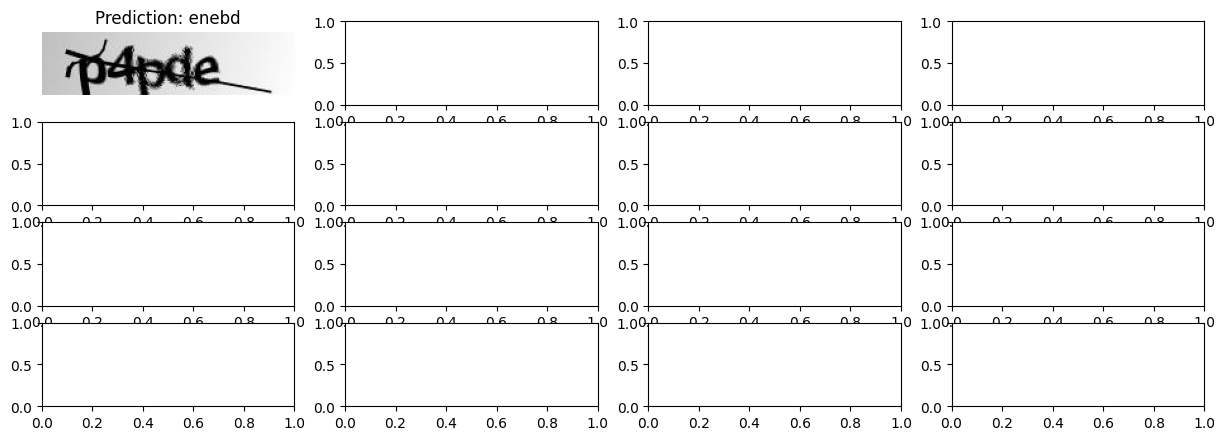

In [26]:
# Inference with TFLite
for batch in validation_dataset.take(1):
  batch_images = batch["image"]
  batch_labels = batch["label"]
input_data = batch_images[0]
interpreter = tf.lite.Interpreter(model_path="/content/ocr_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.expand_dims(input_data, 0)
# input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output = interpreter.get_tensor(output_details[0]['index'])

pred_texts = decode_batch_predictions(output)

orig_texts = []
for label in batch_labels:
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    orig_texts.append(label)

_, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(len(pred_texts)):
    img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
    img = img.T
    title = f"Prediction: {pred_texts[i]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()